In [399]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

### Post process the data

In [400]:
np.random.seed(2)
df = pd.read_csv('processedData.csv')
df.loc[:,'dx'] = df['x'].diff().fillna(0.0) 
df.loc[:,'dy'] = df['y'].diff().fillna(0.0)
df['accX'] = df.accX.ffill().add(df.accX.bfill()).div(2)
df['accY'] = df.accY.ffill().add(df.accY.bfill()).div(2)
df['accZ'] = df.accZ.ffill().add(df.accZ.bfill()).div(2)
df['gyrX'] = df.gyrX.ffill().add(df.gyrX.bfill()).div(2)
df['gyrY'] = df.gyrY.ffill().add(df.gyrY.bfill()).div(2)
df['gyrZ'] = df.gyrZ.ffill().add(df.gyrZ.bfill()).div(2) 
train, test = train_test_split(df, test_size=0.2)
train.head()

,Unnamed: 0,Unnamed: 0.1,time,accX,accY,accZ,gyrX,gyrY,gyrZ,y,x,dx,dy
92,94,94,1.867831,-0.22,-0.17,10.33,-0.002182,0.005454,0.049087,-0.387921,0.039882,0.000287,-0.004959
172,175,175,3.459269,-0.60,-0.51,10.23,0.016362,0.002182,-0.028362,-0.805292,0.067908,0.000543,-0.004543
41,43,43,0.856596,0.49,-0.03,9.16,-0.042542,0.014181,-0.068722,-0.147312,0.015154,0.000669,-0.003692
64,66,66,1.318401,-0.13,-0.07,9.64,0.041452,-0.050178,-0.010908,-0.252145,0.029569,0.000480,-0.004630
109,111,111,2.199016,0.06,-0.28,9.68,0.090539,-0.065450,0.017453,-0.471676,0.044279,0.000256,-0.005169


In [401]:
Xtrain = np.column_stack([train["accX"], train["accY"], train["accZ"], train["gyrX"], train["gyrY"], train["gyrZ"]])#.T
Ytrain = np.column_stack([train["dx"], train["dy"]])#.T
Xtest = np.column_stack([test["accX"], test["accY"], test["accZ"], test["gyrX"], test["gyrY"], test["gyrZ"]])#.T
Ytest = np.column_stack([test["dx"], test["dy"]])#.T

In [402]:
nX = np.shape(Xtrain)[1]
nH1 = 100
nH2 = 16
nY = np.shape(Ytrain)[1]
nX

6

In [403]:
class NN(nn.Module):
    
    def __init__(self, input_size, hidden1_size, hidden2_size, num_classes):
        
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2_size, num_classes)
        #self.fc3 = nn.Linear(hidden1_size, num_classes)  
           
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

In [404]:
model = NN(nX, nH1, nH2, nY)
model = model.float()

### Convert data into a torch dataset

In [405]:
torch.manual_seed(42)
tensor_Xtrain = torch.from_numpy(Xtrain.astype(np.float32))
tensor_Ytrain = torch.from_numpy(Ytrain.astype(np.float32))
tensor_Xtest = torch.from_numpy(Xtest.astype(np.float32))
tensor_Ytest = torch.from_numpy(Ytest.astype(np.float32))
train_dataset = torch.utils.data.TensorDataset(tensor_Xtrain, tensor_Ytrain)
test_dataset = torch.utils.data.TensorDataset(tensor_Xtest, tensor_Ytest)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=8, shuffle=False)
# for data in train_dataset:
#     print(data)
test_loader  = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=8, shuffle=False)

### Cost function and optimizer

In [406]:
cost = nn.MSELoss()#nn.L1Loss()
alpha = 0.01
#optimizer = torch.optim.Adam(model.parameters(), lr=alpha)#, weight_decay=0.001)

optimizer = torch.optim.SGD(model.parameters(), lr=alpha, nesterov=True, momentum=0.9, dampening=0)  

### Train

In [407]:
episodes = 2000
train_loss = []
test_loss = []
for epis in range(episodes):
    for i, data in enumerate(train_loader):
        model.train(True)
        X, y = data
        model.zero_grad()
        output = model(X)#.view(-1, 6))
        loss = cost(output, y)
        loss.backward()
        optimizer.step()
    #model.eval()
    # We don't need gradients on to do reporting
    model.train(False)
    train_loss.append(loss.item())
    for j, testData in enumerate(test_loader):
        testX, testY = testData
        testOutput = model(testX)
        testLoss = cost(testOutput, testY)
    test_loss.append(testLoss.item())
    print(loss)

tensor(1.2163e-05, grad_fn=<MseLossBackward>)
tensor(5.5963e-06, grad_fn=<MseLossBackward>)
tensor(4.1479e-06, grad_fn=<MseLossBackward>)
tensor(4.2442e-06, grad_fn=<MseLossBackward>)
tensor(4.9004e-06, grad_fn=<MseLossBackward>)
tensor(5.1388e-06, grad_fn=<MseLossBackward>)
tensor(5.4472e-06, grad_fn=<MseLossBackward>)
tensor(5.7345e-06, grad_fn=<MseLossBackward>)
tensor(5.9845e-06, grad_fn=<MseLossBackward>)
tensor(6.2284e-06, grad_fn=<MseLossBackward>)
tensor(6.4469e-06, grad_fn=<MseLossBackward>)
tensor(6.6427e-06, grad_fn=<MseLossBackward>)
tensor(6.8138e-06, grad_fn=<MseLossBackward>)
tensor(6.9705e-06, grad_fn=<MseLossBackward>)
tensor(7.1240e-06, grad_fn=<MseLossBackward>)
tensor(7.2457e-06, grad_fn=<MseLossBackward>)
tensor(7.3568e-06, grad_fn=<MseLossBackward>)
tensor(7.4652e-06, grad_fn=<MseLossBackward>)
tensor(7.5603e-06, grad_fn=<MseLossBackward>)
tensor(7.6415e-06, grad_fn=<MseLossBackward>)
tensor(7.7113e-06, grad_fn=<MseLossBackward>)
tensor(7.7708e-06, grad_fn=<MseLos

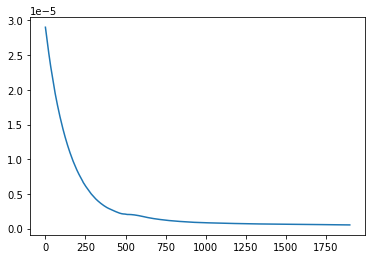

In [408]:
plt.plot(test_loss[100:]);

In [409]:
predicted = model(tensor_Xtrain.float()).detach()
predictedV = model(tensor_Xtest.float()).detach()
loss = cost(predictedV,  tensor_Ytest.float().detach())
loss


tensor(1.3727e-06)

In [410]:
Xpred = predicted.detach().numpy()[:,0]
Ypred = predicted.detach().numpy()[:,1]
Xreal = tensor_Ytrain.float().detach().numpy()[:,0]
Yreal = tensor_Ytrain.float().detach().numpy()[:,1]
XpredV = predictedV.detach().numpy()[:,0]
YpredV = predictedV.detach().numpy()[:,1]
XrealV = tensor_Ytest.float().detach().numpy()[:,0]
YrealV = tensor_Ytest.float().detach().numpy()[:,1]


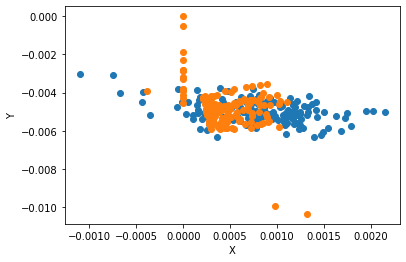

In [411]:
plt.scatter(Xpred, Ypred)
plt.scatter(Xreal, Yreal)
#plt.plot(tensor_Xtrain.float().detach().numpy()[:100] , predicted[:100] , "red")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

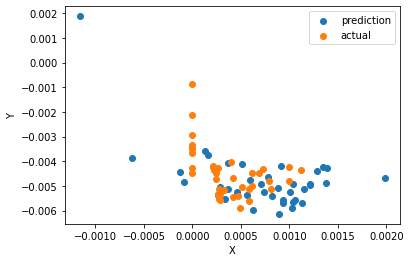

In [412]:
pred = plt.scatter(XpredV, YpredV)
act = plt.scatter(XrealV, YrealV)
plt.legend((pred, act), ('prediction', 'actual'))
#plt.plot(tensor_Xtrain.float().detach().numpy()[:100] , predicted[:100] , "red")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

### Save model

In [413]:
import os
cwd = os.getcwd()
Path = "./3.model.pth"
torch.save(model.state_dict(), Path)

### Load model

In [356]:
saved_model = NN(nX, nH1, nH2, nY)
saved_model.load_state_dict(torch.load("./2.model.pth"))

<All keys matched successfully>

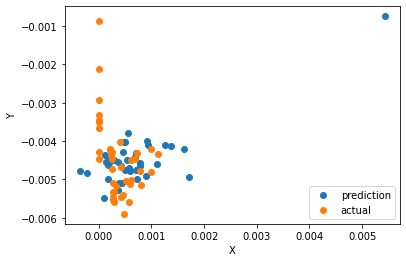

In [416]:
predicted = saved_model(tensor_Xtest.float()).detach()
predictedV = saved_model(tensor_Xtest.float()).detach()
XpredV = predictedV.detach().numpy()[:,0]
YpredV = predictedV.detach().numpy()[:,1]
XpredV = predictedV.detach().numpy()[:,0]
YpredV = predictedV.detach().numpy()[:,1]


#print(len(XpredV), len(YpredV), len(X))
#XrealV = tensor_Ytest.float().detach().numpy()[:,0]
#YrealV = tensor_Ytest.float().detach().numpy()[:,1]
pred = plt.scatter(XpredV, YpredV)
act = plt.scatter(XrealV, YrealV)
plt.legend((pred, act), ('prediction', 'actual'))
#plt.plot(tensor_Xtrain.float().detach().numpy()[:100] , predicted[:100] , "red")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()